In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

In [2]:
outliers_df = pd.read_csv('outliers-data.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   prev_sold_date  7757 non-null   object 
 6   price           7757 non-null   float64
dtypes: float64(6), object(1)
memory usage: 424.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   price           7757 non-null   float64
 6   prev_sold_year  7757 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 424.3 KB


In [5]:
features = ["bed","bath","acre_lot","zip_code","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

In [6]:
#"bed","bath","acre_lot","zip_code","house_size","prev_sold_year"
X = outliers_df[features]
y = outliers_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [7]:
results_dict = {"model":[],"mae score":[],"mse score":[],"r2 score":[]}

In [8]:
def print_more_stuff(title, y_param, predict_param):
    results_dict["model"].append(title)
    
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)    
    
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)

In [9]:
knn = KNeighborsRegressor()
knn_model = knn.fit(X_train,y_train)
knn_predict = knn_model.predict(X_test)
print_more_stuff("K Neighbors Regressor", y_test, knn_predict)

K Neighbors Regressor MSE = 111,235,014,608.881195
K Neighbors Regressor MAE = 197,331.982646
K Neighbors Regressor R2 = 0.442013


In [10]:
knn_sfs = SequentialFeatureSelector(KNeighborsRegressor(), n_features_to_select=num_features_to_select)
knn_sfs.fit(X, y)
knn_sfs_selected_features = knn_sfs.get_support()
print('The selected features are:', list(X.columns[knn_sfs_selected_features]))

The selected features are: ['bed', 'bath', 'acre_lot', 'zip_code', 'prev_sold_year']


In [11]:
X_sfs = outliers_df[list(X.columns[knn_sfs_selected_features])]
y_sfs = outliers_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [12]:
knn_sfs = KNeighborsRegressor()
knn_sfs_model = knn_sfs.fit(X_sfs_train,y_sfs_train)
knn_sfs_predict = knn_sfs_model.predict(X_sfs_test)
print_more_stuff("Sequential Feature Selector", y_test, knn_sfs_predict)

Sequential Feature Selector MSE = 77,068,405,869.755127
Sequential Feature Selector MAE = 164,925.231186
Sequential Feature Selector R2 = 0.613403


In [13]:
knn_pipe = Pipeline([('model', KNeighborsRegressor())])

In [14]:
knn_gscv = GridSearchCV(knn_pipe, param_grid={'model__n_neighbors': range(1, 10, 1)})

In [15]:
knn_gscv.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': range(1, 10)})

In [16]:
print(f"Best parameters found: {knn_gscv.best_params_}")

Best parameters found: {'model__n_neighbors': 6}


In [17]:
knn_clf_predict_test = knn_gscv.best_estimator_.predict(X_test)
print_more_stuff("Grid Search CV",y_test,knn_clf_predict_test)

Grid Search CV MSE = 70,482,416,038.302139
Grid Search CV MAE = 155,674.315006
Grid Search CV R2 = 0.646440


In [18]:
pipeline_params = {}
for what in knn_gscv.best_params_:
    if pipeline_params.get(what) == None:
        pipeline_params[what] = []
    pipeline_params[what].append(knn_gscv.best_params_[what])

In [19]:
knn_gscv_bp = GridSearchCV(knn_pipe, param_grid=pipeline_params)
knn_gscv_bp.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': [6]})

In [20]:
knn_bp_predict_test = knn_gscv_bp.predict(X_test)
print_more_stuff("Best Params",y_test,knn_bp_predict_test)

Best Params MSE = 112,050,463,356.049591
Best Params MAE = 197,695.058276
Best Params R2 = 0.437923


In [21]:
knn_bp_predict_test_df = pd.DataFrame(knn_bp_predict_test).reset_index()
knn_bp_predict_test_df.rename(columns={0: "prediction"},inplace=True)

knn_predict_df = pd.DataFrame(knn_predict).reset_index()
knn_predict_df.rename(columns={0: "prediction"},inplace=True)

knn_sfs_predict_df = pd.DataFrame(knn_sfs_predict).reset_index()
knn_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

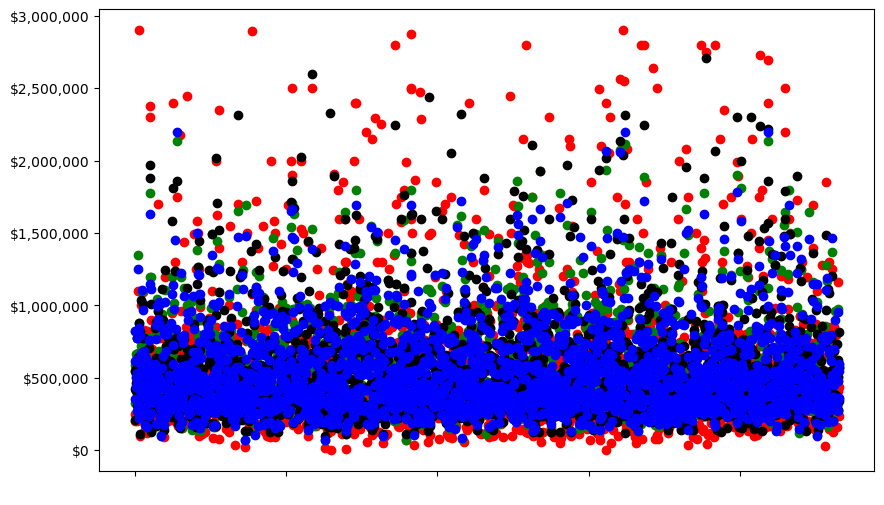

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(knn_predict_df.index,knn_predict_df["prediction"], color="green")
plt.scatter(knn_sfs_predict_df.index,knn_sfs_predict_df["prediction"], color="black")
plt.scatter(knn_bp_predict_test_df.index,knn_bp_predict_test_df["prediction"], color="blue")
plt.show()

In [23]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,mae score,mse score,r2 score
model,,,
K Neighbors Regressor,"197,331.982646","111,235,014,608.881195",0.442013
Sequential Feature Selector,"164,925.231186","77,068,405,869.755127",0.613403
Grid Search CV,"155,674.315006","70,482,416,038.302139",0.646440
Best Params,"197,695.058276","112,050,463,356.049591",0.437923
